# Bruco (Brute force coherence) Pythonチュートリアル

Brucoは**「総当たりコヒーレンス（Brute force coherence）」**を計算するためのツールです。重力波検出器（LIGOやVirgo）の主チャンネル（ターゲット）と、多数の補助チャンネルとの間のコヒーレンスを計算し、ノイズ源を特定することを目的としています。

#### 並列処理によるコヒーレンス計算

Pythonの `multiprocessing` モジュールを使用して複数のCPUコアで並列実行されます。

1. **タスク分割**: 全補助チャンネルリストをCPU数に応じて分割し、各プロセスに割り当てます。
2. **データ取得と前処理**:
* 各補助チャンネルのデータを取得します。
* データが一定（フラット）の場合はスキップします。
* サンプリングレートが出力要求レート (`outfs`) より高い場合、`decimate` 関数を用いてダウンサンプリングします。
3. **コヒーレンス算出**:
* 補助チャンネルのFFTとPSD（パワースペクトル密度）を計算します。
* ターゲットチャンネルとのCSD（クロススペクトル密度）を計算します。
* コヒーレンス  を以下の式で計算します：
4. **Top N の選出**:
* すべての周波数ビンについて、計算されたコヒーレンス値が既存の上位リスト（`top`）よりも高い場合、その値を更新します。これにより、全チャンネルの結果を保持するのではなく、相関の高い上位チャンネルのみを効率的に記録します。
5. **結果の集約と出力**:
* 各プロセスから返された `cohtab`（コヒーレンス値）と `idxtab`（チャンネルID）を結合・ソートし、最終的な上位リストを作成します。
* **HTMLレポート作成**: `markup.py` を使用して `index.html` を生成します。これには、周波数ごとの上位相関チャンネルの表（ヒートマップ形式の着色あり）や、プロット画像へのリンクが含まれます。
* **プロット作成**: `matplotlib` を使用して、コヒーレンスとスペクトルのグラフ（PNGまたはPDF）を生成します。

この実装は、大量のチャンネルデータを効率的に処理するために、**FFTの事前計算**、**並列処理**、および**メモリ効率の良いTop-N記録方式**を採用している点が特徴です。

オリジナルのBruco実装は以下で公開されています。設計詳細やCLIの挙動を確認したい場合はこちらを参照してください。
- https://github.com/mikelovskij/bruco

このノートブックでは `gwexpy` の `Bruco` モジュールを **Pythonライブラリとして** 使う利点を体感するために、
対話的な解析・柔軟なデータ操作・高度な仮説検証を一通り実演します。

- 実データは使わず、`gwpy` / `numpy` で生成した擬似データを利用します。
- CLIでは難しい「非線形結合」や「変調」の仮説検証を、Python APIで高速に試します。


## セットアップとモックデータ生成

**何をするか**: ターゲット/補助チャンネルの擬似データを作り、Brucoに食わせるための `TimeSeries` を準備します。  
**なぜ重要か**: 実運用ではNDSやフレームから取得しますが、ノートブック上で自由に信号を設計できると仮説検証が加速します。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from gwpy.astro import inspiral_range

from gwexpy.analysis import Bruco
from gwexpy.analysis.bruco import FastCoherenceEngine
from gwexpy.noise import from_pygwinc

aLIGO ASD at 100 Hz: 3.71e-24 strain/sqrt(Hz)
Target data std: 1.81e-01


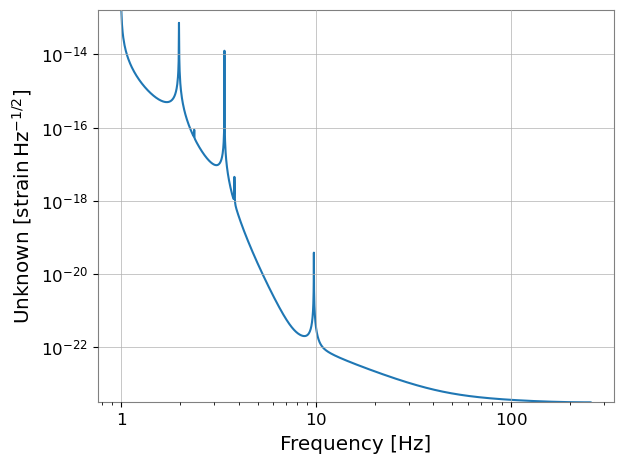

In [2]:
rng = np.random.default_rng(7)

duration = 128  # seconds
sample_rate = 512  # Hz
fftlength = 4.0  # seconds
overlap = 2.0  # seconds

t = np.arange(0, duration, 1 / sample_rate)

# aLIGOの感度曲線(ASD)を取得
fmax = sample_rate / 2  # Nyquist frequency
asd_aligo = from_pygwinc('aLIGO', fmin=1.0, fmax=fmax, df=1.0/duration)

def generate_colored_noise_from_asd(asd, duration, sample_rate, rng=None):
    """
    ASD (FrequencySeries) から、そのスペクトル特性を持つ時系列データを生成する。
    FFTベースのカラードノイズ合成を使用。
    """
    if rng is None:
        rng = np.random.default_rng()
    
    N = int(duration * sample_rate)  # サンプル数
    df = 1.0 / duration
    fft_freqs = np.fft.rfftfreq(N, d=1.0/sample_rate)
    
    # ASDを必要な周波数ビンに補間
    asd_interp = np.interp(fft_freqs, asd.frequencies.value, asd.value, left=asd.value[0], right=asd.value[-1])
    
    # ASDをPSDに変換し、FFT振幅にスケーリング
    # P(f) = ASD^2, FFT振幅 = sqrt(P(f) * N * sample_rate / 2)
    psd = asd_interp ** 2
    amplitudes = np.sqrt(psd * N * sample_rate / 2)
    
    # ランダム位相を持つ複素FFT係数を生成
    phases = rng.uniform(0, 2 * np.pi, size=len(fft_freqs))
    fft_coeffs = amplitudes * np.exp(1j * phases)
    
    # DC成分とNyquist成分は実数
    fft_coeffs[0] = np.real(fft_coeffs[0])
    if N % 2 == 0:
        fft_coeffs[-1] = np.real(fft_coeffs[-1])
    
    # 逆FFTで時系列を生成
    noise = np.fft.irfft(fft_coeffs, n=N)
    
    return noise

# aLIGOの感度曲線に基づくターゲットノイズを生成
target_base = generate_colored_noise_from_asd(asd_aligo, duration, sample_rate, rng)

# 補助チャンネル用の信号
fast_line = np.sin(2 * np.pi * 60.0 * t)
slow_motion = 0.7 * np.sin(2 * np.pi * 0.3 * t) + 0.3 * np.sin(2 * np.pi * 0.8 * t)

aux1_data = 0.8 * fast_line + 0.2 * rng.normal(0, 1.0, size=t.size)
aux2_data = 0.9 * slow_motion + 0.2 * rng.normal(0, 1.0, size=t.size)

# ターゲットへの注入信号
injection_sq = 0.08 * (fast_line ** 2 - np.mean(fast_line ** 2))
injection_prod = 0.06 * fast_line * slow_motion

# ターゲットデータ: aLIGOベースノイズ + 線形カップリング + 非線形注入
target_data = target_base + 0.25 * fast_line + injection_sq + injection_prod

# チャンネル名（実環境の命名規則に合わせて変更可能）
target_channel = "H1:TARGET"
aux1_channel = "H1:AUX1_FAST"
aux2_channel = "H1:AUX2_SLOW"

target = TimeSeries(target_data, sample_rate=sample_rate, t0=0)
aux1 = TimeSeries(aux1_data, sample_rate=sample_rate, t0=0)
aux2 = TimeSeries(aux2_data, sample_rate=sample_rate, t0=0)

target.name = target_channel
aux1.name = aux1_channel
aux2.name = aux2_channel

aux_dict = TimeSeriesDict({
    aux1_channel: aux1,
    aux2_channel: aux2,
})

print(f'aLIGO ASD at 100 Hz: {asd_aligo.crop(99, 101).value[0]:.2e} strain/sqrt(Hz)')
print(f'Target data std: {target_data.std():.2e}')
asd_aligo.plot();

## Section 1: 基本的なBruco解析の実行 (Jupyter上での再現)

**何をするか**: `Bruco` クラスで総当たりコヒーレンス解析を実行し、結果をテーブルとプロットで確認します。  
**なぜ重要か**: Python APIなら、対話的に条件や可視化を変えながら“犯人探し”を素早く試せます。


In [3]:
import gwexpy.analysis.bruco as bruco_module

bruco = Bruco(target_channel, list(aux_dict.keys()))

# Brucoは内部でTimeSeries.getを呼ぶため、ここではモックに差し替えます。
# 実運用ではこのブロックを削除し、NDS/フレームから取得してください。

def mock_get_target(channel, start, end, **kwargs):
    if channel != target_channel:
        raise KeyError(channel)
    return target


def mock_get_aux(channels, start, end, **kwargs):
    return TimeSeriesDict({name: aux_dict[name] for name in channels})


orig_ts_get = bruco_module.TimeSeries.get
orig_tsd_get = bruco_module.TimeSeriesDict.get
bruco_module.TimeSeries.get = mock_get_target
bruco_module.TimeSeriesDict.get = mock_get_aux

try:
    result = bruco.compute(
        start=0,
        duration=int(duration),
        fftlength=fftlength,
        overlap=overlap,
        nproc=1,
        batch_size=2,
        top_n=3,
        spectrum="asd",
    )
finally:
    bruco_module.TimeSeries.get = orig_ts_get
    bruco_module.TimeSeriesDict.get = orig_tsd_get


In [4]:
df = result.to_dataframe(ranks=[0])

df_sorted = (
    df.sort_values("coherence", ascending=False)
    .dropna(subset=["channel"])
    .head(15)
    .reset_index(drop=True)
)

df_sorted


,frequency,rank,channel,coherence,projection
0,60.00,1,H1:AUX1_FAST,0.998105,3.444546e-01
1,59.75,1,H1:AUX1_FAST,0.976437,1.726795e-01
2,60.25,1,H1:AUX1_FAST,0.973982,1.724624e-01
3,0.25,1,H1:AUX2_SLOW,0.143452,1.886570e-05
4,0.75,1,H1:AUX2_SLOW,0.135985,6.682839e-10
5,0.50,1,H1:AUX2_SLOW,0.133652,6.621425e-10
6,1.00,1,H1:AUX2_SLOW,0.130662,6.555415e-10
7,10.50,1,H1:AUX1_FAST,0.120025,7.521727e-10
8,206.50,1,H1:AUX2_SLOW,0.117295,2.110798e-11
9,191.00,1,H1:AUX1_FAST,0.101631,2.635787e-11


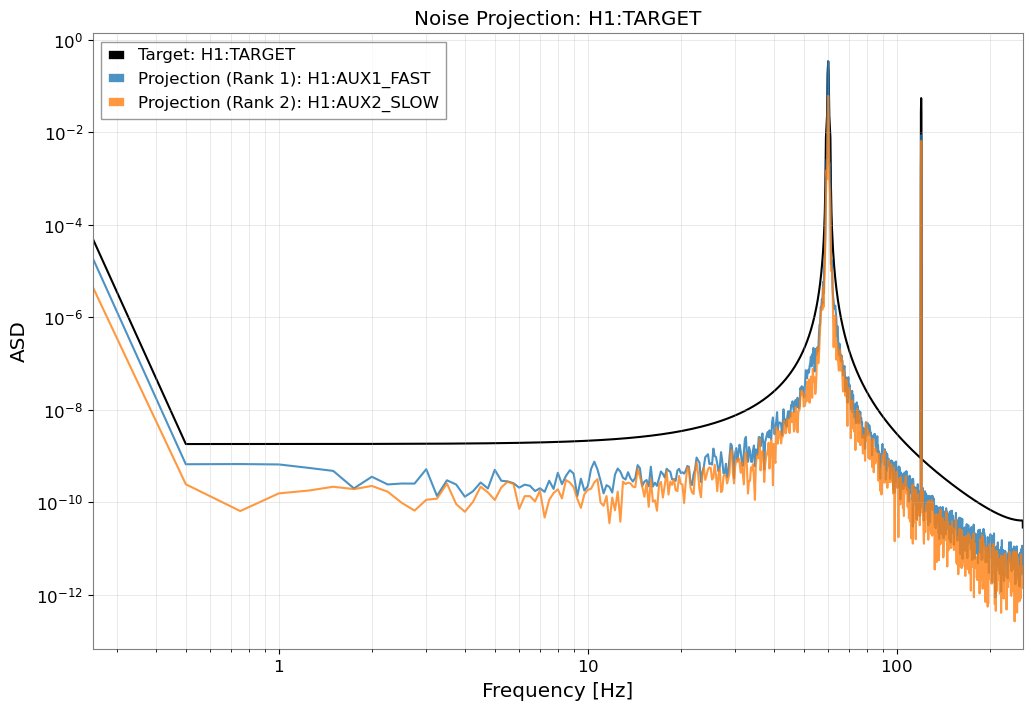

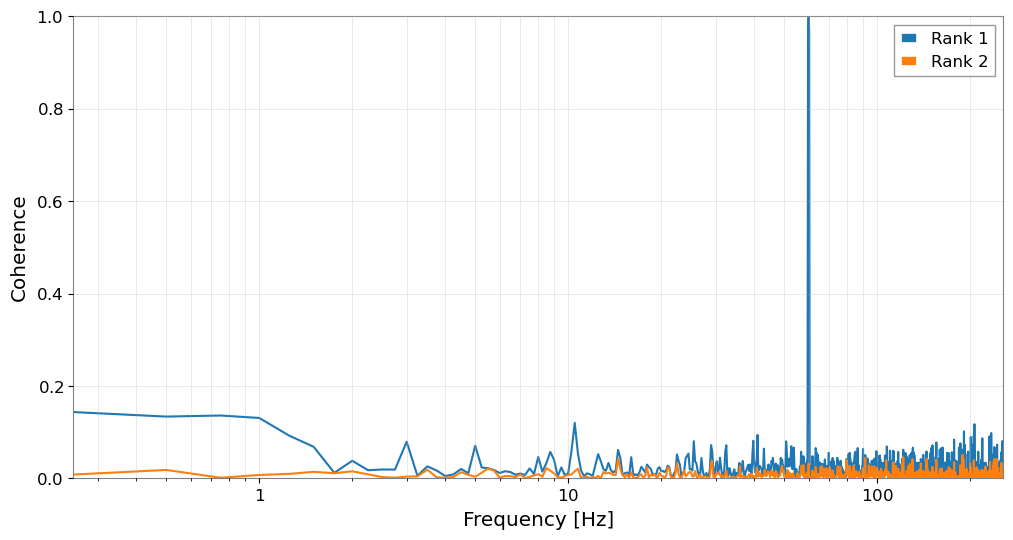

In [5]:
result.plot_projection(ranks=[0, 1])
plt.show()

result.plot_coherence(ranks=[0, 1])
plt.show()


In [6]:
report_path = result.generate_report("bruco_report", coherence_threshold=0.4)
report_path


'bruco_report/index.html'

## Section 2: 高度な前処理と仮説検証 (Deep Dive: Nonlinear & Bilinear)

**何をするか**: 既存の線形相関だけでは説明できないノイズを想定し、非線形結合（2乗）や変調（積）を仮説として検定します。  
**なぜ重要か**: `FastCoherenceEngine` を使うと、ターゲットのFFTを再計算せずに仮想チャンネルを高速に試せます。


In [7]:
ts_sq = TimeSeries(
    aux1.value ** 2 - np.mean(aux1.value ** 2),
    sample_rate=sample_rate,
    t0=0,
)

ts_prod = TimeSeries(
    aux1.value * aux2.value,
    sample_rate=sample_rate,
    t0=0,
)

ts_sq.name = f"{aux1.name}^2"
ts_prod.name = f"{aux1.name}*{aux2.name}"


In [8]:
engine = FastCoherenceEngine(target, fftlength=fftlength, overlap=overlap)

coh_linear = engine.compute_coherence(aux1)
coh_sq = engine.compute_coherence(ts_sq)
coh_prod = engine.compute_coherence(ts_prod)

freqs = engine.frequencies


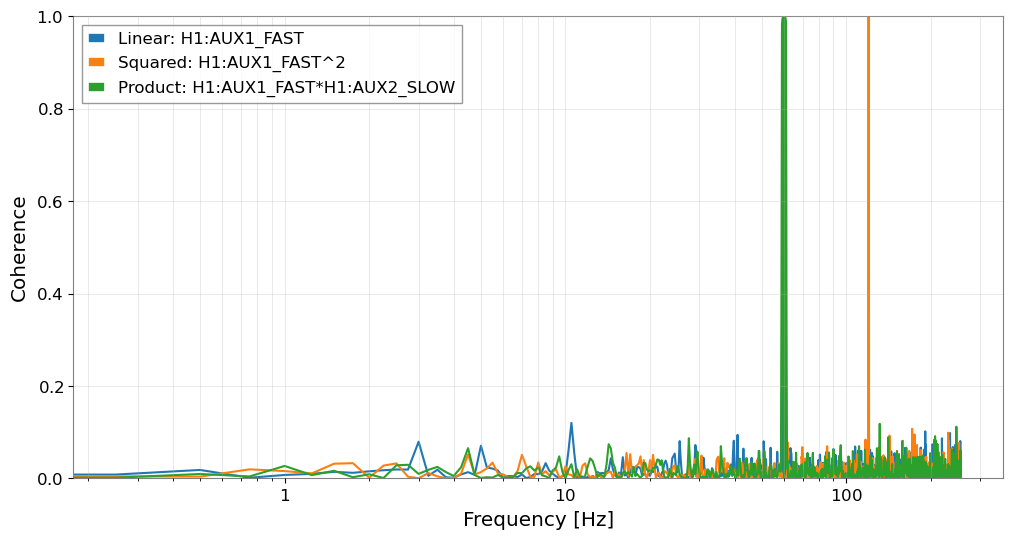

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.semilogx(freqs, coh_linear, label=f"Linear: {aux1.name}")
ax.semilogx(freqs, coh_sq, label=f"Squared: {ts_sq.name}")
ax.semilogx(freqs, coh_prod, label=f"Product: {ts_prod.name}")

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Coherence")
ax.set_ylim(0.0, 1.0)
ax.grid(True, which="both", ls="-", alpha=0.4)
ax.legend()
plt.show()


## Section 3: 下流解析への接続 (Actionable Outcome)

**何をするか**: もっとも寄与が大きいノイズ仮説を用いて残差スペクトルを推定し、BNS Rangeの改善量を見積もります。  
**なぜ重要か**: Bruco結果を“見つけて終わり”にせず、感度改善やノイズ除去ワークフローにつなげられます。


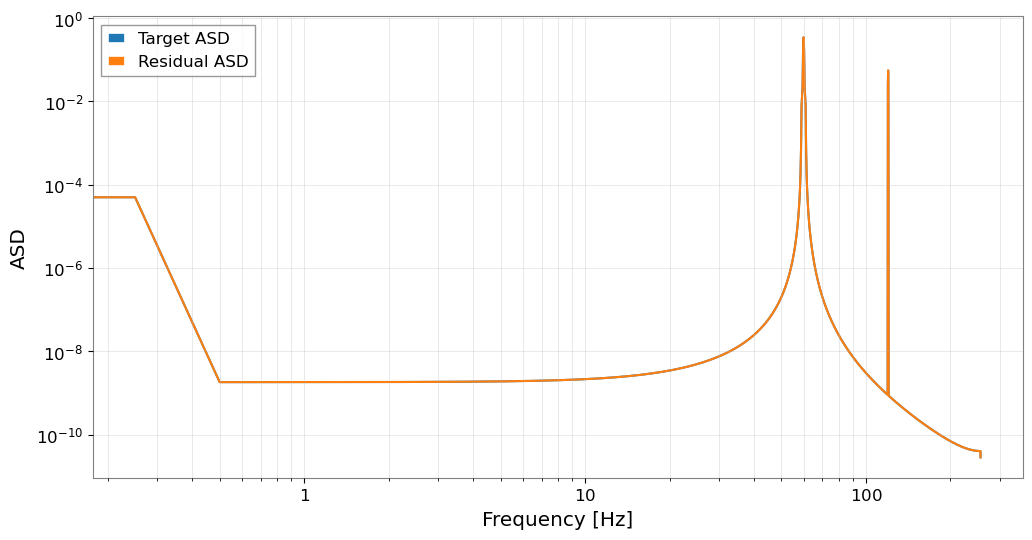

RuntimeError: Could not find root of <lambda> inside z=1000.

In [10]:
target_asd = target.asd(fftlength=fftlength, overlap=overlap)
target_asd_vals = target_asd.value

coh_map = {
    aux1.name: coh_linear,
    ts_sq.name: coh_sq,
    ts_prod.name: coh_prod,
}

dominant_label = max(coh_map, key=lambda k: np.nanmax(coh_map[k]))
dominant_coh = coh_map[dominant_label]

# Brucoの投影式と同じ定義で、仮想チャンネルの寄与をASDで推定
projected_asd = target_asd_vals * np.sqrt(dominant_coh)
residual_asd_vals = np.sqrt(np.maximum(target_asd_vals ** 2 - projected_asd ** 2, 0.0))

residual_asd = target_asd.copy()
#residual_asd.value = residual_asd_vals

fig, ax = plt.subplots(figsize=(12, 6))
#ax.loglog(target_asd.frequencies.value, target_asd_vals, label="Target ASD")
#ax.loglog(target_asd.frequencies.value, residual_asd_vals, label="Residual ASD")
ax.loglog(target_asd, label="Target ASD")
ax.loglog(residual_asd, label="Residual ASD")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("ASD")
ax.grid(True, which="both", ls="-", alpha=0.4)
ax.legend()
plt.show()

# BNS Rangeの比較
bns_range_before = inspiral_range(target_asd ** 2, mass1=1.4, mass2=1.4, fmin=10)
bns_range_after = inspiral_range(residual_asd ** 2, mass1=1.4, mass2=1.4, fmin=10)

print(f"Dominant hypothesis: {dominant_label}")
print(f"BNS range (before): {bns_range_before.to_value(u.Mpc):.2f} Mpc")
print(f"BNS range (after):  {bns_range_after.to_value(u.Mpc):.2f} Mpc")


In [ ]:
virtual_channels = {
    aux1.name: aux1,
    ts_sq.name: ts_sq,
    ts_prod.name: ts_prod,
}

culprit_channels = [dominant_label]
witnesses = TimeSeriesDict({name: virtual_channels[name] for name in culprit_channels})

cxx = witnesses.csd_matrix(fftlength=8.0)
cyx = TimeSeriesDict({"TARGET": target}).csd_matrix(other=witnesses, fftlength=8.0)

# 行列演算 H = Cyx @ Cxx^-1
H_lowres = cyx @ cxx.inv()

# 推定された伝達関数の表示
H_lowres.abs().plot(xscale="log", yscale="log").suptitle("Estimated MIMO Coupling (H)")
plt.show()

# フル解像度のFFT
tsd_fft = tsd.fft()
main_fft = tsd_fft["MAIN"]

# フィルターの補間と行列演算
H = H_lowres.interpolate(main_fft.frequencies)
X_mat = FrequencySeriesDict({k: tsd_fft[k] for k in aux_names}).to_matrix()

# 投影と減算
Y_proj = (H @ X_mat)[0, 0]
cleaned_fft = main_fft - Y_proj

# 時間領域へ
cleaned_ts = cleaned_fft.ifft()
